# Mixture Models


Notebook to play around with the Iris dataset and Mixture Models


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
penguin_df = (
    pd.read_csv("./data/penguins_size.csv").drop(columns=["island", "sex"]).dropna()
)
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


<IPython.core.display.Javascript object>

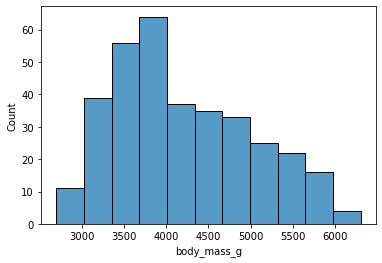

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(penguin_df.body_mass_g)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_penguin_df = scaler.fit_transform(penguin_df.drop(columns=["species"]))
scaled_penguin_df = pd.DataFrame(scaled_penguin_df, columns=penguin_df.columns[1:])
scaled_penguin_df["species"] = list(penguin_df["species"])
scaled_penguin_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie
...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo


<IPython.core.display.Javascript object>

In [5]:
scaled_penguin_df.groupby(["species"]).agg(
    mean_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="mean"),
    std_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="std"),
    mean_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="mean"),
    std_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="std"),
    mean_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="mean"),
    std_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="std"),
    mean_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="mean"),
    std_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="std"),
)

,mean_culmen_length,std_culmen_length,mean_culmen_depth,std_culmen_depth,mean_flipper_length,std_flipper_length,mean_body_mass,std_body_mass
species,,,,,,,,
Adelie,-0.941108,0.488555,0.606109,0.616992,-0.780675,0.465735,-0.625754,0.572648
Chinstrap,0.901001,0.612528,0.643753,0.575786,-0.362625,0.507928,-0.585261,0.479950
Gentoo,0.657229,0.565313,-1.099980,0.497600,1.158865,0.461855,1.091761,0.629531


<IPython.core.display.Javascript object>

In [34]:
n_clusters = 3
data = scaled_penguin_df.drop(columns=["species"]).values
n_observations, n_features = data.shape
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=n_features,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    μ = pm.Normal(
        "μ", 0.0, 1.5, shape=(n_clusters, n_features), testval=data.mean(axis=0)
    )

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    obs = pm.MvNormal("obs", μ[category], chol=chol, observed=data)

    trace = pm.sample(8000)

<ipython-input-34-eedb7fbe77e6>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(8000)
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [p, μ, chol]
INFO:pymc3:>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]
INFO:pymc3:>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 960 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 960 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarnin

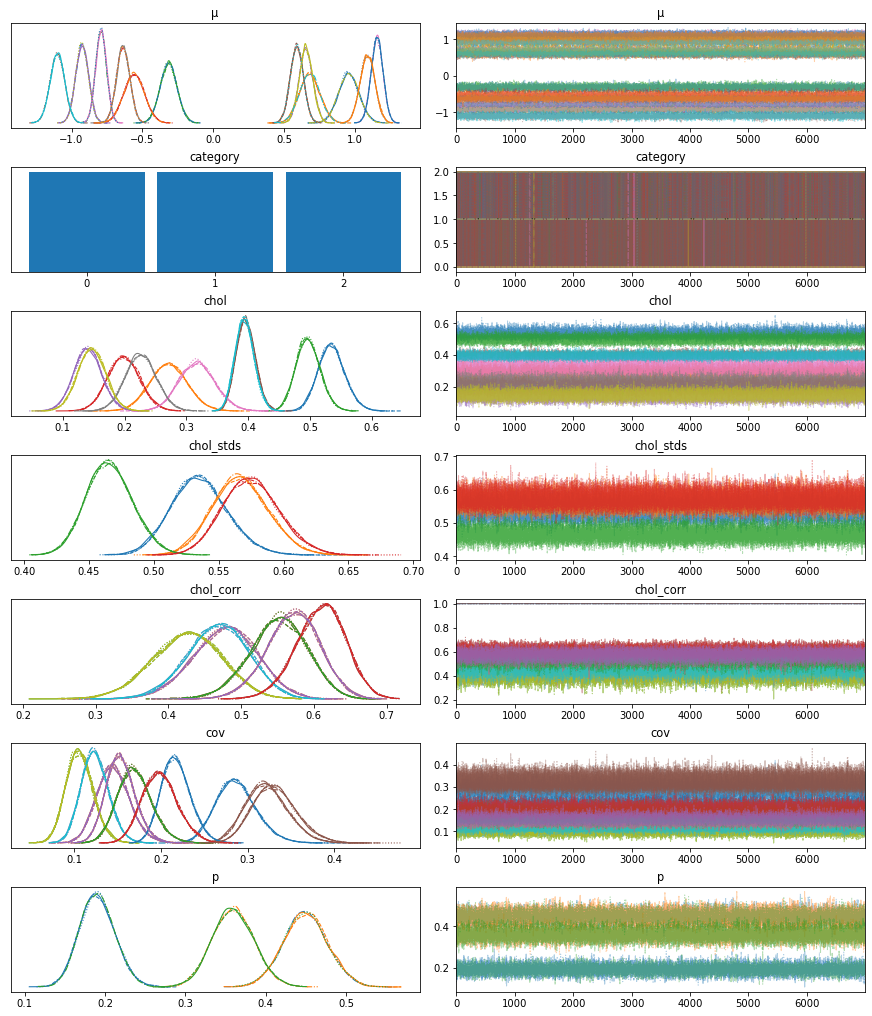

<IPython.core.display.Javascript object>

In [35]:
with model:
    pm.plot_trace(trace[1000:])

In [48]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=1000, combine=False)[2][1000])
]
penguin_df["group"] = groups
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,group
0,Adelie,39.1,18.7,181.0,3750.0,Group 2
1,Adelie,39.5,17.4,186.0,3800.0,Group 2
2,Adelie,40.3,18.0,195.0,3250.0,Group 2
4,Adelie,36.7,19.3,193.0,3450.0,Group 2
5,Adelie,39.3,20.6,190.0,3650.0,Group 2
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Group 3
340,Gentoo,46.8,14.3,215.0,4850.0,Group 3
341,Gentoo,50.4,15.7,222.0,5750.0,Group 3
342,Gentoo,45.2,14.8,212.0,5200.0,Group 3


<IPython.core.display.Javascript object>

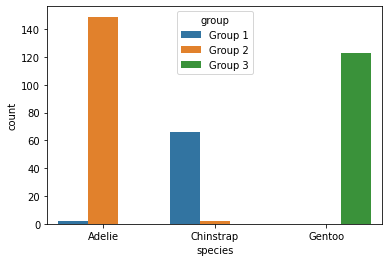

<IPython.core.display.Javascript object>

In [49]:
plot_df = (
    penguin_df.groupby(["species", "group"])
    .count()[["culmen_length_mm"]]
    .reset_index()
    .rename(columns={"culmen_length_mm": "count"})
)

_ = sns.barplot(data=plot_df, x="species", y="count", hue="group")

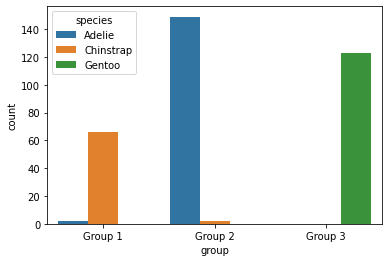

<IPython.core.display.Javascript object>

In [50]:
_ = sns.barplot(data=plot_df, x="group", y="count", hue="species")

This is an even better separation than the previous model, and while it is (for me) difficult to grok what exactly is happening you can't argue with these results.